In [2]:
from PIL import Image
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay
import pickle
import random

#l load block design
System = Overlay("./LeNet-5/LeNet-5.bit")

# make np.array to print completely
# you can commit this
np.set_printoptions(threshold=np.inf)

# instance xlnk
xlink = Xlnk()

# the hls ipcore
cnn = System.LeNet_Hw_0

# load trained weights and bias data 
# conv layer1
conv1_w_d = np.array(np.load('./LeNet-5/weight/conv1_weight.npy'))
conv1_w_n = conv1_w_d
conv1_w_d = conv1_w_d.flatten()
conv1_b_d = np.array(np.load('./LeNet-5/weight/conv1_bias.npy'))
# convlayer 2
conv2_w_d = np.array(np.load('./LeNet-5/weight/conv2_weight.npy'))
conv2_w_d = conv2_w_d.flatten()
conv2_b_d = np.array(np.load('./LeNet-5/weight/conv2_bias.npy'))
# fc layer 1
fc1_w_d = np.array(np.load('./LeNet-5/weight/fc1_weight.npy'))
fc1_w_d = fc1_w_d.flatten()
fc1_b_d = np.array(np.load('./LeNet-5/weight/fc1_bias.npy'))
# fc layer 2
fc2_w_d = np.array(np.load('./LeNet-5/weight/fc2_weight.npy'))
fc2_w_d = fc2_w_d.flatten()
fc2_b_d = np.array(np.load('./LeNet-5/weight/fc2_bias.npy'))


# allocate cma storage for weights and bias
conv1_w = xlink.cma_array(dtype=np.float32, shape=conv1_w_d.shape)
conv1_b = xlink.cma_array(dtype=np.float32, shape=conv1_b_d.shape)
conv2_w = xlink.cma_array(dtype=np.float32, shape=conv2_w_d.shape)
conv2_b = xlink.cma_array(dtype=np.float32, shape=conv2_b_d.shape)
fc1_w = xlink.cma_array(dtype=np.float32, shape=fc1_w_d.shape)
fc1_b = xlink.cma_array(dtype=np.float32, shape=fc1_b_d.shape)
fc2_w = xlink.cma_array(dtype=np.float32, shape=fc2_w_d.shape)
fc2_b = xlink.cma_array(dtype=np.float32, shape=fc2_b_d.shape)
output_data = xlink.cma_array(shape=(43,), dtype=np.float32)
input_data = xlink.cma_array(shape=(3072,),dtype=np.float32)

# value the cma_arrays
for i in range(0, len(conv1_w)):
    conv1_w[i] = conv1_w_d[i]
    
for i in range(0, len(conv2_w)):
    conv2_w[i] = conv2_w_d[i]
    
for i in range(0,  len(fc1_w)):
    fc1_w[i] = fc1_w_d[i]

for i in range(0, len(fc2_w)):
    fc2_w[i] = fc2_w_d[i] 

for i in range(0, len(conv1_b)):
    conv1_b[i] = conv1_b_d[i]
    
for i in range(0, len(conv2_b)):
    conv2_b[i] = conv2_b_d[i]
    
for i in range(0, len(fc1_b)):
    fc1_b[i] = fc1_b_d[i]

for i in range(0, len(fc2_b)):
    fc2_b[i] = fc2_b_d[i]

In [3]:
# write the address to the ip core
cnn.write(0x10, conv1_w.physical_address)
cnn.write(0x18, conv1_b.physical_address)
cnn.write(0x20, conv2_w.physical_address)
cnn.write(0x28, conv2_b.physical_address)
cnn.write(0x30, fc1_w.physical_address)
cnn.write(0x38, fc1_b.physical_address)
cnn.write(0x40, fc2_w.physical_address)
cnn.write(0x48, fc2_b.physical_address)
cnn.write(0x50, input_data.physical_address)
cnn.write(0x58, output_data.physical_address)

# you can also load these datasets, but it may take too much storage
#training_file = './LeNet-5/dataset/train.p'
# testing_file = './LeNet-5/dataset/test.p'
validation_file = './LeNet-5/dataset/valid.p'


# read these data files
# with open(training_file, mode='rb') as f:
#     train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
# with open(testing_file, mode='rb') as f:
#     test = pickle.load(f)

# get and handle x and labels, train, verify, test
# X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
# X_test, y_test = test['features'], test['labels']


In [122]:
# use this def to input a ramdom image from valid.p
# you can also input train.p or test.p similarly
def input_random_sign():
    global input_data
    pic = random.randint(0, 4409)
    image = Image.fromarray(X_valid[pic], 'RGB') 
    display(image)
    input_data_x = X_valid[pic].flatten()/255.
    # X_test = X_test / 255.
    for i in range(0, 32*32*3):
        input_data[i] = input_data_x[i]
    cnn.write(0x00, 0x01)

# use this def to read out the conclusion
def draw_conclusion():    
    global output_data
    i = cnn.read(0x00)
    while i != 6:
        i = cnn.read(0x00)
    label = np.argmax(output_data)
    display(Image.open('./LeNet-5/images/typical/'+format(label,'01d')+'.jpg'))

# use this def to input a jpg file for recongnition
def input_jpg_file(jpg_file=None):
    global input_data
    source_img = Image.open(jpg_file)
    display(source_img)
    array = np.array(source_img)
    new_img_32 = source_img.resize((32, 32), Image.BILINEAR)
    input_array = np.array(new_img_32)
    input_array = input_array.flatten()
    for i in range(0, 32*32*3):
        input_data[i] = input_array[i]
    cnn.write(0x00, 0x01)

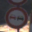

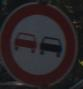

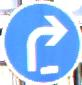

In [137]:
# this is a executing
# excample
# the first picture is the random image get from valid.p
# the second is cnn matched conclulusion, these pictures are in the depository of LeNet-5/images/typical/...
# the third one is a jpg file put in, there are 00000.jpg to 12629.jpg in path LeNet-5/images/jpgfile/...
input_random_sign()
draw_conclusion()
input_jpg_file(jpg_file='./LeNet-5/images/jpgfile/06657.jpg')
draw_conclusion()